## Import the Libraries

In [1]:
from termcolor import colored
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import re
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
from datetime import date, datetime
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
# featuretools for automated feature engineering
import featuretools as ft
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Colab Setting for iploty

https://colab.research.google.com/drive/14oudHx5e5r7hm1QcbZ24FVHXgVPD0k8f

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
import IPython

IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

# EDA Functions 


## 1. missing_values_table(df)


In [4]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df,  column = None,condition = None):
        """Compute the missing values number and percentage:
        df: Table;
        column: One column in the table used only if filtering apply, feature name;
        condition: For filtering the data tabel;
        
        Example1:
        df = table,
        Call the function:
        missing_values_table(df = tabel)        

        Example2:
        df = table,
        column = 'DATE',
        condition = '2019-05-01' 
        
        Call the function:
        missing_values_table(df = orders,column = 'DATE', condition = '2019-05-01' )
        """       
        
        if column and condition:
            df = df[df[column] >=  condition]
        else:
            df = df.copy()

        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print (colored("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" + "and has rows: "+ str(df.shape[0]) +'\n'   + 
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " features that have missing values.",'blue'))

        # Return the dataframe with missing information
        #if ploting:
         #   plt.figure(figsize=(18,4))
         #   sns.heatmap(orders.isnull(),yticklabels=False)
         #   plt.show()
        return mis_val_table_ren_columns

## 2. Plot the missing values

In [6]:
def missing_values_plotting(df):
    """Plot the missing values number and percentage:
    df: Table;

    Example1:
    df = orders_table,
    Call the function:
    missing_values_plotting(df = orders_tabel)        
    """  
    plt.figure(figsize=(18,4))
    sns.heatmap(df.isnull(),yticklabels=False)
    plt.show()

## 3. find_unique_count_values_column(df)


In [7]:
# Function to calculate uniques values by column# Funct 
def find_unique_count_values_column(df):
    """Return the features types, sorted count of categorical features and values:
        df: Table;

        Example:
        df = orders_table;
        
        Call the function:
        find_unique_count_values_column(df= orders_table)"""    
    
    # Dictionary to save the column name and unique values
    columns_unique_values = {}
    
    # Select categorical columns
    for col in df.columns:
        if df[col].dtypes == 'object':
            
            # Save a tuple values has both count of unique values and unique values itselfs
            columns_unique_values[col]=(df[col].dtypes, df[col].nunique(),[df[col].unique()]) 
            
    # Return a data Frame
    myfun = pd.DataFrame(columns_unique_values)
    
    myfun.index = ['Feature Type', 'Count of Unique Values', 'Uniques Values']
    return myfun.T.sort_values('Count of Unique Values')


## 4. eda_columns(df , col)

In [8]:
def eda_columns(df , column):
    """Funtion to compute the EDA, Pie Chart
    df: Table;
    column: One column in the table, feature name;
    
    Example:
    df = orders_table,
    
    Call the function:
    eda_columns(df = orders , col = 'CART_TYPE') """
    import cufflinks as cf
    cf.go_offline()
    cf.set_config_file(offline=False, world_readable=True)
    
    
    # Count the values
    temp = df[column].value_counts()
    
    # Return the index and the value itself
    df = pd.DataFrame({'labels': temp.index,
                       'values': temp.values
                      })
    
    # Compute the plot kind
    return df.iplot(kind='pie',labels='labels',values='values', title= column, hole = 0.5)


## 5. correlation_matrix(data)


In [9]:
def correlation_features_drop(df, condition_num):
    """Compute the correlation matrix and delete features with high correlation
    df: Table;
    condition_num: For filtering the set of features that have high correlation;

    Example:
    df = table,
    condition_num = x,
    
    Call the function:
    correlation_features_drop(df= table, condition_num= x)
    """       
    # Find the correlation matrix
    plt.figure(figsize=(12,7))

    corr_matrix = df.corr()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than condition_num
    to_drop = [column for column in upper.columns if any(abs(upper[column]) > condition_num)]
    
    #print(f'There are {len(to_drop)} correlated columns to remove.', " ", to_drop)
    #sns.pairplot(corr_matrix)
    ax = sns.heatmap(upper)

    return ax ,to_drop


## 6. plot_distribution(df, target , list1, classes=[0, 1]):

In [11]:
def plot_distribution(df, target , list1):
    """Funtion to compute the kde distribution to understand the feature importance
    df: Table
    Target: Class label;
    List1: Provide a list of columns to compute their distribution; 
    Classes : 0 , 1, 2;
    
    Example:
    df = table;
    
    Call the function:
    plot_distribution(df = table, target = 'class' , 
                          list1 = ['x1', 'x2']) """
   
    if len(list1) >=2:
        plt.figure(figsize = (8, 14))
    else:
        plt.figure(figsize = (8, 8))

    # plt.style.use('fivethirtyeight')
    for i, source in enumerate(list1):
        plt.subplot(len(list1), 1, i + 1)

        if df[source].dtype == 'O':
                  raise TypeError("Categorical variables must be encoded first to plot distribution")
        try:
            # KDE plot of labels :Male 
            sns.kdeplot(df.loc[df[target] == 0, source] , label = 'Class == Male', color='green')

            # KDE plot of labels :Female 
            sns.kdeplot(df.loc[df[target] == 1, source] , label = 'Class == Female', color ='red')


            # Labeling of plot
            plt.xlabel(source); plt.ylabel('Density'); plt.title('Distribution of '+ str(source));
        except:
            print("Function only accept numeric features")

## 7. eda_advanced(df, col, filter_col, groups1 , target_name,  target_values, taret_labels )

In [12]:
def eda_advanced(df, col, filter_col, groups1 , target_name,  target_values, taret_labels ):
  """ Compute Classes distribution w.r.t some feature
  
  Example:
        df = dataset
        col ='sex',
        filter_col = 'age',
        groups1= ['female', 'male'],
        target_name ='survived', 
        target_values= [0, 1],
        taret_labels = ['Not survived', 'Survived']
  """
  # EDA - distributions - advanced 
  group_11 = df[df[col]==groups1[0]]
  group_21 = df[df[col]==groups1[1]]

  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))

  # distribution for survived men
  ax = sns.distplot(group_21[group_21[target_name]==target_values[1]][filter_col].dropna(), bins=22, label = taret_labels[1], ax = axes[0], kde =False)
  ax = sns.distplot(group_21[group_21[target_name]==target_values[0]][filter_col].dropna(), bins=40, label = taret_labels[0], ax = axes[0], kde =False)
  ax.legend()
  ax.set_title(groups1[1])

  # distribution for survived women 
  ax = sns.distplot(group_11[group_11[target_name]==target_values[1]][filter_col].dropna(), bins=22, label = taret_labels[1], ax = axes[1], kde = False)
  ax = sns.distplot(group_11[group_11[target_name]==target_values[0]][filter_col].dropna(), bins=40, label = taret_labels[0], ax = axes[1], kde = False)
  ax.legend()
  ax.set_title(groups1[0])

  return ax

## 8. count_plot(df, col)


In [13]:
def count_plot(df, column):
    """Funtion to compute the EDA, Count Values
    df: Table;
    column: One column in the table, feature name;
    
    Example:
    df = table,
    
    Call the function:
    count_plot(df = table , column = 'ACTIVE_WATCH_RESULT') """
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(7,7))
    
    # Create countplot
    ax = sns.countplot(x= column, data=df )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=8)
    plt.title('Distribution of ' + column, fontsize=12, fontweight='bold')


## 9. def remove_constant_column(df)

In [203]:
def remove_constant_column(df):
  """To remove constant values- low variability, as they do not provide extra information"""

  to_del = []
  # Find count of unique values
  counts = df.nunique()

  # Return the null or constant values columns
  for i,v in enumerate(counts):
      if v<=1:
          to_del.append(counts.index[i])
          
  print('There are some features with constant value or 100% null: ',len(to_del))
  return to_del


##  Read data

In [204]:
# Download from https://www.openml.org/d/40945
# Data description 
# http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf
df = pd.read_csv('/content/df_titanic.csv')
df.head(3)

pclass  survived                            name     sex     age  sibsp  parch  ticket      fare    cabin embarked boat body                        home.dest
0       1         1   Allen, Miss. Elisabeth Walton  female      29      0      0   24160  211.3375       B5        S    2    ?                     St Louis, MO
1       1         1  Allison, Master. Hudson Trevor    male  0.9167      1      2  113781    151.55  C22 C26        S   11    ?  Montreal, PQ / Chesterville, ON
2       1         0    Allison, Miss. Helen Loraine  female       2      1      2  113781    151.55  C22 C26        S    ?    ?  Montreal, PQ / Chesterville, ON

# Perform Data Cleansing - Preprocessing 

In [205]:
# EDA- Cleaning 
df.replace('?',np.NaN,inplace=True)
df.tail(10)

pclass  survived                                     name     sex   age  sibsp  parch  ticket     fare cabin embarked boat body home.dest
1299       3         0                      Yasbeck, Mr. Antoni    male    27      1      0    2659  14.4542   NaN        C    C  NaN       NaN
1300       3         1  Yasbeck, Mrs. Antoni (Selini Alexander)  female    15      1      0    2659  14.4542   NaN        C  NaN  NaN       NaN
1301       3         0                     Youseff, Mr. Gerious    male  45.5      0      0    2628    7.225   NaN        C  NaN  312       NaN
1302       3         0                        Yousif, Mr. Wazli    male   NaN      0      0    2647    7.225   NaN        C  NaN  NaN       NaN
1303       3         0                    Yousseff, Mr. Gerious    male   NaN      0      0    2627  14.4583   NaN        C  NaN  NaN       NaN
1304       3         0                     Zabour, Miss. Hileni  female  14.5      1      0    2665  14.4542   NaN        C  NaN  328       NaN
1305       3         0                    Zabour, Miss. Thamine  female   NaN      1      0    2665  14.4542   NaN        C  NaN  NaN       NaN
1306       3         0                Zakarian, Mr. Mapriededer    male  26.5      0      0    2656    7.225   NaN        C  NaN  304       NaN
1307       3         0                      Zakarian, Mr. Ortin    male    27      0      0    2670    7.225   NaN        C  NaN  NaN       NaN
1308       3         0                       Zimmerman, Mr. Leo    male    29      0      0  315082    7.875   NaN        S  NaN  NaN       NaN

In [206]:
# EDA- cleaning
df_clean = df.copy()
df_clean[[c for c in df_clean.columns ]] = df_clean[[c for c in df_clean.columns]].replace('NaN', np.nan)
print(" The df_clean shape before dropping duplicates is: {}".format(df_clean.shape))
df_clean.drop_duplicates( keep='first', inplace=True)
print(" The df_clean shape is after dropping the duplicates: {}".format(df_clean.shape))

 The df_clean shape before dropping duplicates is: (1309, 14)
 The df_clean shape is after dropping the duplicates: (1309, 14)


In [207]:
# EDA- Cleaning
for col in df_clean.columns:
    if df_clean[col].dtypes == 'object':
        df_clean[col] = df_clean[col].str.replace(r'[^A-Za-z0-9,. -.]', '') 
        df_clean[col] = df_clean[col].str.replace('""', '')
        df_clean[col] = df_clean[col].str.replace('"', '')
        df_clean[col] = df_clean[col].str.replace("'","")
df_clean.head()

pclass  survived                                             name     sex     age  sibsp  parch  ticket      fare    cabin embarked boat body                       home.dest
0       1         1                    Allen, Miss. Elisabeth Walton  female      29      0      0   24160  211.3375       B5        S    2  NaN                    St Louis, MO
1       1         1                   Allison, Master. Hudson Trevor    male  0.9167      1      2  113781    151.55  C22 C26        S   11  NaN  Montreal, PQ  Chesterville, ON
2       1         0                     Allison, Miss. Helen Loraine  female       2      1      2  113781    151.55  C22 C26        S  NaN  NaN  Montreal, PQ  Chesterville, ON
3       1         0             Allison, Mr. Hudson Joshua Creighton    male      30      1      2  113781    151.55  C22 C26        S  NaN  135  Montreal, PQ  Chesterville, ON
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female      25      1      2  113781    151.55  C22 C26        S  NaN  NaN  Montreal, PQ  Chesterville, ON

In [208]:
# EDA- Check missing value and thier percentage
mis_values = missing_values_table(df)
mis_values

Your selected dataframe has 14 columns.
and has rows: 1309
There are 7 features that have missing values.


Missing Values  % of Total Values
body                 1188               90.8
cabin                1014               77.5
boat                  823               62.9
home.dest             564               43.1
age                   263               20.1
embarked                2                0.2
fare                    1                0.1

In [209]:
# EDA - drop columns with large missing values
columns_to_drop = mis_values[mis_values['% of Total Values'] >= 40].index
columns_to_drop

Index(['body', 'cabin', 'boat', 'home.dest'], dtype='object')

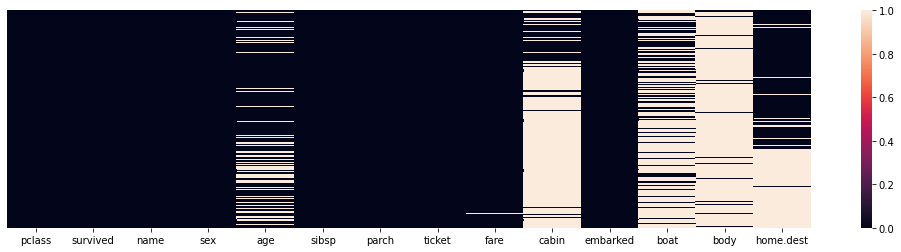

In [210]:
missing_values_plotting(df)

In [211]:
# EDA - understand data
find_unique_count_values_column(df)


Feature Type Count of Unique Values                                     Uniques Values
sex             object                      2                                   [[female, male]]
embarked        object                      3                                   [[S, C, nan, Q]]
boat            object                     27  [[2, 11, nan, 3, 10, D, 4, 9, 6, B, 8, A, 5, 7...
age             object                     98  [[29, 0.9167, 2, 30, 25, 48, 63, 39, 53, 71, 4...
body            object                    121  [[nan, 135, 22, 124, 148, 208, 172, 269, 62, 1...
cabin           object                    186  [[B5, C22 C26, E12, D7, A36, C101, nan, C62 C6...
fare            object                    281  [[211.3375, 151.55, 26.55, 77.9583, 0, 51.4792...
home.dest       object                    369  [[St Louis, MO, Montreal, PQ / Chesterville, O...
ticket          object                    929  [[24160, 113781, 19952, 13502, 112050, 11769, ...
name            object                   1307  [[Allen, Miss. Elisabeth Walton, Allison, Mast...

In [212]:
# EDA - cleaning
# To explain how the function works, let's add two dummy column, then drop them!
dfd = df.copy()
dfd['dummy_col1'] = np.nan* pd.Series(range(dfd.shape[0]))
dfd['dummy_col2'] = 'dummy variable'
dfd.head(5)

pclass  survived                                             name     sex     age  sibsp  parch  ticket      fare    cabin embarked boat body                        home.dest  dummy_col1      dummy_col2
0       1         1                    Allen, Miss. Elisabeth Walton  female      29      0      0   24160  211.3375       B5        S    2  NaN                     St Louis, MO         NaN  dummy variable
1       1         1                   Allison, Master. Hudson Trevor    male  0.9167      1      2  113781    151.55  C22 C26        S   11  NaN  Montreal, PQ / Chesterville, ON         NaN  dummy variable
2       1         0                     Allison, Miss. Helen Loraine  female       2      1      2  113781    151.55  C22 C26        S  NaN  NaN  Montreal, PQ / Chesterville, ON         NaN  dummy variable
3       1         0             Allison, Mr. Hudson Joshua Creighton    male      30      1      2  113781    151.55  C22 C26        S  NaN  135  Montreal, PQ / Chesterville, ON         NaN  dummy variable
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female      25      1      2  113781    151.55  C22 C26        S  NaN  NaN  Montreal, PQ / Chesterville, ON         NaN  dummy variable

In [213]:
to_remove = remove_constant_column(dfd)
to_remove

There are some features with constant value or 100% null:  2


['dummy_col1', 'dummy_col2']

In [214]:
# EDA -understand data
eda_columns(df, 'sex') #sex

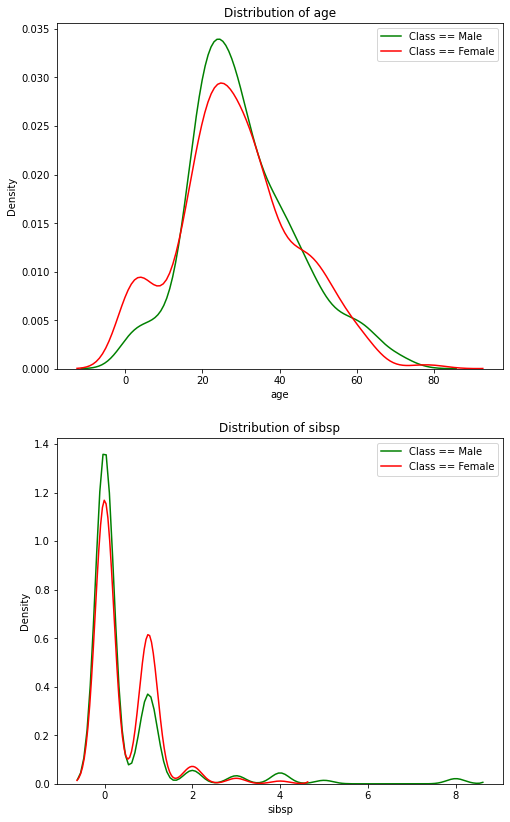

In [215]:
# EDA- KDE disribution 
df['age'] = df['age'].astype('float64')
df['sibsp'] = df['sibsp'].astype('int64')
df['parch'] = df['parch'].astype('int64')
plot_distribution(df, 'survived', list1=['age', 'sibsp'])

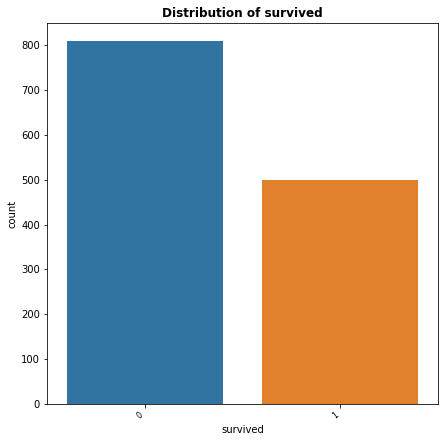

In [216]:
# EDA - class imbalance check
count_plot(df, 'survived')

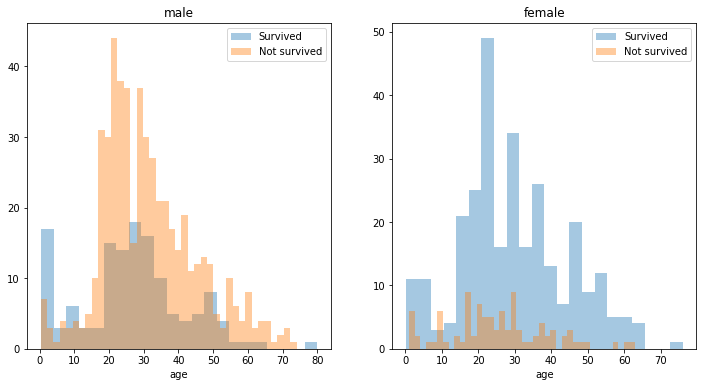

In [217]:
# EDA- Distribution Advanced

eda_advanced(df, col ='sex',
                 filter_col = 'age',
                 groups1= ['female', 'male'],
                 target_name ='survived', 
                 target_values= [0, 1],
                 taret_labels = ['Not survived', 'Survived'])


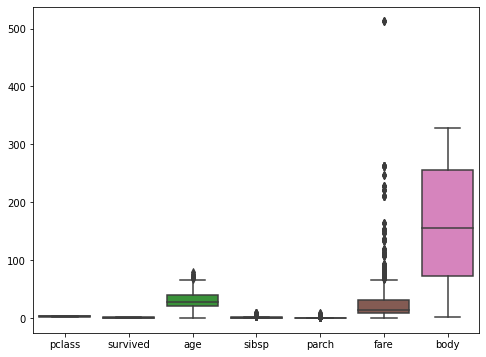

In [218]:
# Outliers
fig = plt.figure(figsize=(8,6))
sns.boxplot(data=df)

# Encoding 

## 1-  One-hot encoding 
### curse of dimensionality 


In [219]:
df_test = df.copy()
df_test = df_test.drop('name',axis=1)
pd.get_dummies(df_test)

pclass  survived      age  sibsp  parch  sex_female  sex_male  ticket_110152  ticket_110413  ticket_110465  ticket_110469  ticket_110489  ticket_110564  ticket_110813  ticket_111163  ticket_111240  ticket_111320  ticket_111361  ticket_111369  ticket_111426  ticket_111427  ticket_111428  ticket_112050  ticket_112051  ticket_112052  ticket_112053  ticket_112058  ticket_112059  ticket_112277  ticket_112377  ticket_112378  ticket_112379  ticket_112901  ticket_113028  ticket_113038  ticket_113043  ticket_113044  ticket_113050  ticket_113051  ticket_113054  ticket_113055  ticket_113056  ticket_113059  ticket_113501  ticket_113503  ticket_113505  ticket_113509  ticket_113510  ticket_113514  ticket_113572  ticket_113760  ticket_113767  ticket_113773  ticket_113776  ticket_113778  ticket_113780  ticket_113781  ticket_113783  ticket_113784  ticket_113786  ticket_113787  ticket_113788  ticket_113789  ticket_113790  ticket_113791  ticket_113792  ticket_113794  ticket_113795  ticket_113796  \
0          1         1  29.0000      0      0           1         0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0   
1          1         1   0.9167      1      2           0         1              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              1              0              0              0              0              0              0              0              0              0              0              0              0   
2          1         0   2.0000      1      2           1         0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              0              1              0              0              0              0              0              0              0              0              0              0              0              0   
3 

# 2- Simple Frequnecy Encoder

In [220]:
# Try this in 5 minutes, write a function to return the frequency percentage of each category in all columns in the previous dataFrame.
def return_frequency(df, col= None):
    """ To encode the categories by their frequency"""
    
    if isinstance(df, pd.DataFrame) and col == None:
      # Exclude the name column
      for col in df.columns:
      # Encode only the categorical values
        if df[col].dtype == 'O':
      # Keep the numerical column and drop the categorical one
          df[col+'_frequency %'] =  df[col].map((df.groupby(col).size())/len(df))*100
          df.drop(col, axis=1, inplace = True)    
    else:
        df[col]=  df[col].map((df.groupby(col).size())/len(df[col]))*100
        return df[col]
    return df

In [221]:
df2 = df.copy()
df2 = return_frequency(df2)
df2.head(5)

pclass  survived      age  sibsp  parch  name_frequency %  sex_frequency %  ticket_frequency %  fare_frequency %  cabin_frequency %  embarked_frequency %  boat_frequency %  body_frequency %  home.dest_frequency %
0       1         1  29.0000      0      0          0.076394        35.599694            0.305577          0.305577           0.152788             69.824293          0.993125               NaN               0.305577
1       1         1   0.9167      1      2          0.076394        64.400306            0.458365          0.458365           0.305577             69.824293          1.909855               NaN               0.305577
2       1         0   2.0000      1      2          0.076394        35.599694            0.458365          0.458365           0.305577             69.824293               NaN               NaN               0.305577
3       1         0  30.0000      1      2          0.076394        64.400306            0.458365          0.458365           0.305577             69.824293               NaN          0.076394               0.305577
4       1         0  25.0000      1      2          0.076394        35.599694            0.458365          0.458365           0.305577             69.824293               NaN               NaN               0.305577

## Use Sklearn Categorical Encoding

In [222]:
from sklearn_pandas import CategoricalImputer
data =df['boat']
imputer = CategoricalImputer()
imputer = imputer.fit_transform(data)
imputer

array(['2', '11', '13', ..., '13', '13', '13'], dtype=object)

# Filling Missing Values

# First option  - fill with zero

In [223]:
# Can we do better?
df3 = df.copy()
df3.fillna(value=0)
df3.head(5)

pclass  survived                                             name     sex      age  sibsp  parch  ticket      fare    cabin embarked boat body                        home.dest
0       1         1                    Allen, Miss. Elisabeth Walton  female  29.0000      0      0   24160  211.3375       B5        S    2  NaN                     St Louis, MO
1       1         1                   Allison, Master. Hudson Trevor    male   0.9167      1      2  113781    151.55  C22 C26        S   11  NaN  Montreal, PQ / Chesterville, ON
2       1         0                     Allison, Miss. Helen Loraine  female   2.0000      1      2  113781    151.55  C22 C26        S  NaN  NaN  Montreal, PQ / Chesterville, ON
3       1         0             Allison, Mr. Hudson Joshua Creighton    male  30.0000      1      2  113781    151.55  C22 C26        S  NaN  135  Montreal, PQ / Chesterville, ON
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0000      1      2  113781    151.55  C22 C26        S  NaN  NaN  Montreal, PQ / Chesterville, ON

# Second option:
### 1. Divide the data into 2 subsets
### 2. Encode categorical subset with most frequent
### 3. Encode numerical subset with mean or median
### 4. Perform joining 

In [224]:
# Let's look at the documnetation and see what's up?
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
from sklearn.impute import SimpleImputer

In [225]:
# Select Only Numerical Subset from the Entire DataFrame
df_numerical = df.select_dtypes(['int64', 'int32', 'float32', 'float64'])
df_numerical.tail(5)

pclass  survived   age  sibsp  parch
1304       3         0  14.5      1      0
1305       3         0   NaN      1      0
1306       3         0  26.5      0      0
1307       3         0  27.0      0      0
1308       3         0  29.0      0      0

In [226]:
# Median Encoding
imp = SimpleImputer(missing_values=np.NaN, strategy='median')
idf = pd.DataFrame(imp.fit_transform(df_numerical), columns=df_numerical.columns)
idf.tail(5)

pclass  survived   age  sibsp  parch
1304     3.0       0.0  14.5    1.0    0.0
1305     3.0       0.0  28.0    1.0    0.0
1306     3.0       0.0  26.5    0.0    0.0
1307     3.0       0.0  27.0    0.0    0.0
1308     3.0       0.0  29.0    0.0    0.0

In [227]:
# Select Only Categorical Subset from the Entire DataFrame
df_categorical = df.select_dtypes('object')
df_categorical.tail(5)

name     sex  ticket     fare cabin embarked boat body home.dest
1304       Zabour, Miss. Hileni  female    2665  14.4542   NaN        C  NaN  328       NaN
1305      Zabour, Miss. Thamine  female    2665  14.4542   NaN        C  NaN  NaN       NaN
1306  Zakarian, Mr. Mapriededer    male    2656    7.225   NaN        C  NaN  304       NaN
1307        Zakarian, Mr. Ortin    male    2670    7.225   NaN        C  NaN  NaN       NaN
1308         Zimmerman, Mr. Leo    male  315082    7.875   NaN        S  NaN  NaN       NaN

In [228]:
imp2 = SimpleImputer(missing_values= np.NaN, strategy= 'most_frequent' )
idf2 = pd.DataFrame(imp2.fit_transform(df_categorical), columns=df_categorical.columns)
idf2.tail(5)

name     sex  ticket     fare        cabin embarked boat body     home.dest
1304       Zabour, Miss. Hileni  female    2665  14.4542  C23 C25 C27        C   13  328  New York, NY
1305      Zabour, Miss. Thamine  female    2665  14.4542  C23 C25 C27        C   13    1  New York, NY
1306  Zakarian, Mr. Mapriededer    male    2656    7.225  C23 C25 C27        C   13  304  New York, NY
1307        Zakarian, Mr. Ortin    male    2670    7.225  C23 C25 C27        C   13    1  New York, NY
1308         Zimmerman, Mr. Leo    male  315082    7.875  C23 C25 C27        S   13    1  New York, NY

In [229]:
# Join the two encoding data frames
idf.join(idf2).tail(5)

pclass  survived   age  sibsp  parch                       name     sex  ticket     fare        cabin embarked boat body     home.dest
1304     3.0       0.0  14.5    1.0    0.0       Zabour, Miss. Hileni  female    2665  14.4542  C23 C25 C27        C   13  328  New York, NY
1305     3.0       0.0  28.0    1.0    0.0      Zabour, Miss. Thamine  female    2665  14.4542  C23 C25 C27        C   13    1  New York, NY
1306     3.0       0.0  26.5    0.0    0.0  Zakarian, Mr. Mapriededer    male    2656    7.225  C23 C25 C27        C   13  304  New York, NY
1307     3.0       0.0  27.0    0.0    0.0        Zakarian, Mr. Ortin    male    2670    7.225  C23 C25 C27        C   13    1  New York, NY
1308     3.0       0.0  29.0    0.0    0.0         Zimmerman, Mr. Leo    male  315082    7.875  C23 C25 C27        S   13    1  New York, NY

# Third option: 
### Write a fucntion to do encoding without dividing the dataset into subsets.

#### Write a small code to impute the numerical missing values by their mean, and categorical missing values by their mode ?

In [230]:
def fillna_value(df, col= None):
  """To fill the missing values either with mean or mode based on their type."""

  if isinstance(df, pd.DataFrame) and col == None:
    for col in df.columns:

      # Impute using the mean
      if df[col].dtype != 'O':
        df= df.fillna(value={col:df[col].mean()})

      # Impute using the mode
      elif df[col].dtype == 'O':
        df = df.fillna(value={col:df[col].mode().max()})
      
    return df

In [231]:
df_testing = df.copy()
df_testing.tail(5)

pclass  survived                       name     sex   age  sibsp  parch  ticket     fare cabin embarked boat body home.dest
1304       3         0       Zabour, Miss. Hileni  female  14.5      1      0    2665  14.4542   NaN        C  NaN  328       NaN
1305       3         0      Zabour, Miss. Thamine  female   NaN      1      0    2665  14.4542   NaN        C  NaN  NaN       NaN
1306       3         0  Zakarian, Mr. Mapriededer    male  26.5      0      0    2656    7.225   NaN        C  NaN  304       NaN
1307       3         0        Zakarian, Mr. Ortin    male  27.0      0      0    2670    7.225   NaN        C  NaN  NaN       NaN
1308       3         0         Zimmerman, Mr. Leo    male  29.0      0      0  315082    7.875   NaN        S  NaN  NaN       NaN

In [232]:
df_filled = fillna_value(df_testing)
df_filled.tail(5)

pclass  survived                       name     sex        age  sibsp  parch  ticket     fare        cabin embarked boat body     home.dest
1304       3         0       Zabour, Miss. Hileni  female  14.500000      1      0    2665  14.4542  C23 C25 C27        C   13  328  New York, NY
1305       3         0      Zabour, Miss. Thamine  female  29.881135      1      0    2665  14.4542  C23 C25 C27        C   13   98  New York, NY
1306       3         0  Zakarian, Mr. Mapriededer    male  26.500000      0      0    2656    7.225  C23 C25 C27        C   13  304  New York, NY
1307       3         0        Zakarian, Mr. Ortin    male  27.000000      0      0    2670    7.225  C23 C25 C27        C   13   98  New York, NY
1308       3         0         Zimmerman, Mr. Leo    male  29.000000      0      0  315082    7.875  C23 C25 C27        S   13   98  New York, NY

In [233]:
pd.DataFrame(df[['cabin','boat', 'home.dest']].describe())

cabin boat     home.dest
count           295  486           745
unique          186   27           369
top     C23 C25 C27   13  New York, NY
freq              6   39            64

In [234]:
df['age'].dropna(inplace=True)
df['age'] = df['age'].astype('int')

In [235]:
df.loc[ df['age'] <= 5, 'age'] = 0
df.loc[(df['age'] > 5)  & (df['age'] <= 15), 'age'] = 1
df.loc[(df['age'] > 15) & (df['age'] <= 20), 'age'] = 2
df.loc[(df['age'] > 20) & (df['age'] <= 25), 'age'] = 3
df.loc[(df['age'] > 25) & (df['age'] <= 35), 'age'] = 4
df.loc[(df['age'] > 35) & (df['age'] <= 45), 'age'] = 5
df.loc[(df['age'] > 45) & (df['age'] <= 55), 'age'] = 6
df.loc[(df['age'] > 55) & (df['age'] <= 70), 'age'] = 7
df.loc[ df['age'] > 66, 'age'] = 8


df.head()

pclass  survived                                             name     sex  age  sibsp  parch  ticket      fare    cabin embarked boat body                        home.dest
0       1         1                    Allen, Miss. Elisabeth Walton  female  4.0      0      0   24160  211.3375       B5        S    2  NaN                     St Louis, MO
1       1         1                   Allison, Master. Hudson Trevor    male  0.0      1      2  113781    151.55  C22 C26        S   11  NaN  Montreal, PQ / Chesterville, ON
2       1         0                     Allison, Miss. Helen Loraine  female  0.0      1      2  113781    151.55  C22 C26        S  NaN  NaN  Montreal, PQ / Chesterville, ON
3       1         0             Allison, Mr. Hudson Joshua Creighton    male  4.0      1      2  113781    151.55  C22 C26        S  NaN  135  Montreal, PQ / Chesterville, ON
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  3.0      1      2  113781    151.55  C22 C26        S  NaN  NaN  Montreal, PQ / Chesterville, ON

In [241]:
eda_columns(df, 'age')

In [240]:
df.loc[ df['age'] <= 3].shape

(443, 14)

# To find a pattern string in a text 

In [0]:
def find_pattern(df, col, word_to_find):
  """To match a string in a text"""

  list1 = []
  for txt in df[col]:
    # use re to find the match
    for match in re.finditer(word_to_find, txt):
      list1.append([txt,match.group(0)])
  print(len(list1))
  return list1 

In [72]:
find_pattern(df, col = 'name', word_to_find = r"Miss")

260


[['Allen, Miss. Elisabeth Walton', 'Miss'],
 ['Allison, Miss. Helen Loraine', 'Miss'],
 ['Andrews, Miss. Kornelia Theodosia', 'Miss'],
 ["Barber, Miss. Ellen 'Nellie'", 'Miss'],
 ['Bazzani, Miss. Albina', 'Miss'],
 ['Bidois, Miss. Rosalie', 'Miss'],
 ['Bird, Miss. Ellen', 'Miss'],
 ['Bissette, Miss. Amelia', 'Miss'],
 ['Bonnell, Miss. Caroline', 'Miss'],
 ['Bonnell, Miss. Elizabeth', 'Miss'],
 ['Bowen, Miss. Grace Scott', 'Miss'],
 ['Bowerman, Miss. Elsie Edith', 'Miss'],
 ['Burns, Miss. Elizabeth Margaret', 'Miss'],
 ['Carter, Miss. Lucile Polk', 'Miss'],
 ['Chaudanson, Miss. Victorine', 'Miss'],
 ['Cherry, Miss. Gladys', 'Miss'],
 ['Cleaver, Miss. Alice', 'Miss'],
 ['Compton, Miss. Sara Rebecca', 'Miss'],
 ['Crosby, Miss. Harriet R', 'Miss'],
 ['Daniels, Miss. Sarah', 'Miss'],
 ['Endres, Miss. Caroline Louise', 'Miss'],
 ['Eustis, Miss. Elizabeth Mussey', 'Miss'],
 ['Evans, Miss. Edith Corse', 'Miss'],
 ['Fleming, Miss. Margaret', 'Miss'],
 ['Fortune, Miss. Alice Elizabeth', 'Miss'],

# Covid-19 Practical Example (2)

In [363]:
# Corona visrus example
# link: 
# Read data
df = pd.read_csv('/content/covid19.csv', encoding="cp1252", error_bad_lines=False)
df = df.sort_values(by='dateRep')
df3 = df.copy()
df.head()

dateRep  day  month  year  cases  deaths countriesAndTerritories geoId countryterritoryCode   popData2018
3114  01/01/2020    1      1  2020      0       0                   India    IN                  IND  1.352617e+09
3553  01/01/2020    1      1  2020      0       0                  Israel    IL                  ISR  8.883800e+06
3196  01/01/2020    1      1  2020      0       0               Indonesia    ID                  IDN  2.676634e+08
219   01/01/2020    1      1  2020      0       0                 Algeria    DZ                  DZA  4.222843e+07
4313  01/01/2020    1      1  2020      0       0                Malaysia    MY                  MYS  3.152858e+07

In [364]:
df.describe()

day        month         year         cases       deaths   popData2018
count  7320.000000  7320.000000  7320.000000   7320.000000  7320.000000  7.311000e+03
mean     16.828142     2.249454  2019.990847     80.870355     3.687158  7.130483e+07
std       8.322981     1.256463     0.095239    608.270244    35.327689  2.140624e+08
min       1.000000     1.000000  2019.000000     -9.000000     0.000000  1.000000e+03
25%      10.000000     1.000000  2020.000000      0.000000     0.000000  4.137309e+06
50%      18.000000     2.000000  2020.000000      0.000000     0.000000  1.072767e+07
75%      24.000000     3.000000  2020.000000      5.000000     0.000000  5.139301e+07
max      31.000000    12.000000  2020.000000  18695.000000   971.000000  1.392730e+09

In [372]:
missing_values_table(df3)

Your selected dataframe has 10 columns.
and has rows: 7320
There are 3 features that have missing values.


Missing Values  % of Total Values
countryterritoryCode              66                0.9
geoId                             14                0.2
popData2018                        9                0.1

In [373]:
find_unique_count_values_column(df3)

Feature Type Count of Unique Values                                     Uniques Values
dateRep                       object                     89  [[01/01/2020, 01/02/2020, 01/03/2020, 02/01/20...
countryterritoryCode          object                    194  [[IND, ISR, IDN, DZA, MYS, CZE, THA, MKD, MCO,...
geoId                         object                    195  [[IN, IL, ID, DZ, MY, CZ, TH, MK, MC, PK, EE, ...
countriesAndTerritories       object                    196  [[India, Israel, Indonesia, Algeria, Malaysia,...

# Time Series Analysis

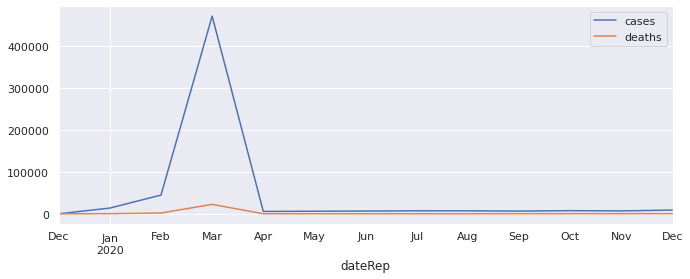

In [365]:
df['dateRep'] = df['dateRep'].astype('datetime64[ns]')
df.index = df['dateRep']
df2 = df.copy()

df = df.resample('M').sum()
df[['cases','deaths']].plot()

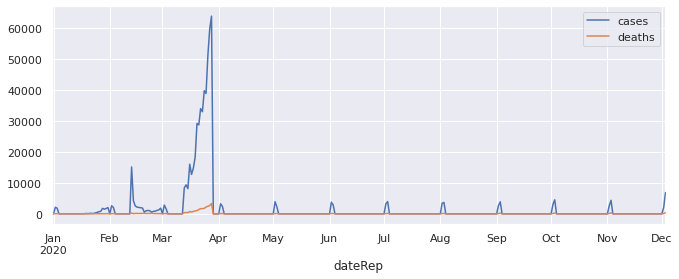

In [366]:
df2 = df2.resample('D').sum()
df2[['cases','deaths']].plot()

## Analyize March Month 03/2020


Text(37.5, 0.5, 'Cases and Deaths Average Value')

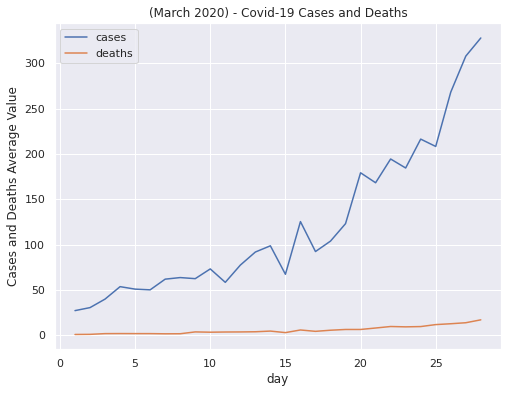

In [370]:
df4 = df3[df3['month']==3]
x = df4[['day','cases', 'deaths']]
x.groupby('day').agg('mean').plot(figsize=(8,6))
plt.title('(March 2020) - Covid-19 Cases and Deaths')
plt.savefig('cov20.jpg')
plt.ylabel('Cases and Deaths Average Value')

## Time Series Per Country

In [374]:
df5 = df3[['countriesAndTerritories','cases','deaths']]
df5 = df5.groupby(['countriesAndTerritories']).agg(['mean'])
df5.columns = ['average_cases_per_country', 'average_deaths_per_country']
df5 = df5.sort_values(by='average_cases_per_country', ascending = False)
df5.head()

average_cases_per_country  average_deaths_per_country
countriesAndTerritories                                                        
United_States_of_America                1176.247191                   19.179775
Italy                                    971.887640                  102.651685
China                                    923.741573                   37.089888
Spain                                    719.764045                   54.584270
Germany                                  545.865169                    3.651685

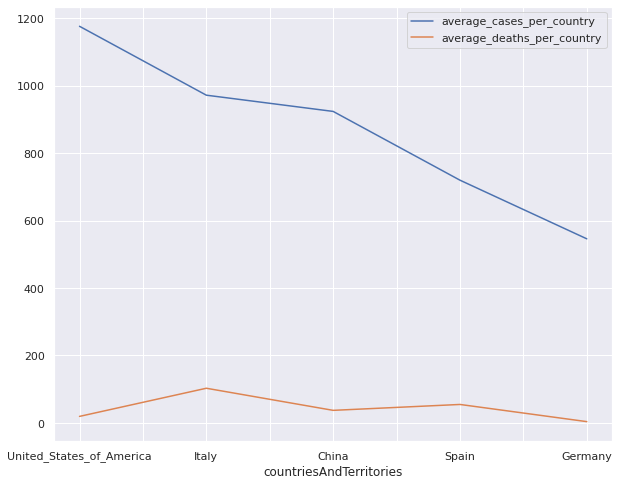

In [377]:
df5[:5].plot(figsize=(10,8))

# Example 3: Genral Dataset

In [243]:
df_new = pd.read_csv('adult_csv.csv')
df_new.head()

age         workclass  fnlwgt  education  education-num      marital-status         occupation   relationship   race     sex  capitalgain  capitalloss  hoursperweek native-country  class
0    2         State-gov   77516  Bachelors             13       Never-married       Adm-clerical  Not-in-family  White    Male            1            0             2  United-States  <=50K
1    3  Self-emp-not-inc   83311  Bachelors             13  Married-civ-spouse    Exec-managerial        Husband  White    Male            0            0             0  United-States  <=50K
2    2           Private  215646    HS-grad              9            Divorced  Handlers-cleaners  Not-in-family  White    Male            0            0             2  United-States  <=50K
3    3           Private  234721       11th              7  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male            0            0             2  United-States  <=50K
4    1           Private  338409  Bachelors             13  Married-civ-spouse     Prof-specialty           Wife  Black  Female            0            0             2           Cuba  <=50K

In [271]:
missing_values_table(df_new)

Your selected dataframe has 15 columns.
and has rows: 48842
There are 3 features that have missing values.


Missing Values  % of Total Values
occupation                2809                5.8
workclass                 2799                5.7
native-country             857                1.8

In [272]:
find_unique_count_values_column(df_new)

Feature Type Count of Unique Values                                     Uniques Values
sex                  object                      2                                   [[Male, Female]]
class                object                      2                                    [[<=50K, >50K]]
race                 object                      5  [[White, Black, Asian-Pac-Islander, Amer-India...
relationship         object                      6  [[Not-in-family, Husband, Wife, Own-child, Unm...
marital-status       object                      7  [[Never-married, Married-civ-spouse, Divorced,...
workclass            object                      8  [[State-gov, Self-emp-not-inc, Private, Federa...
occupation           object                     14  [[Adm-clerical, Exec-managerial, Handlers-clea...
education            object                     16  [[Bachelors, HS-grad, 11th, Masters, 9th, Some...
native-country       object                     41  [[United-States, Cuba, Jamaica, India, nan, Me...

(<matplotlib.axes._subplots.AxesSubplot at 0x7f46b428b160>, [])

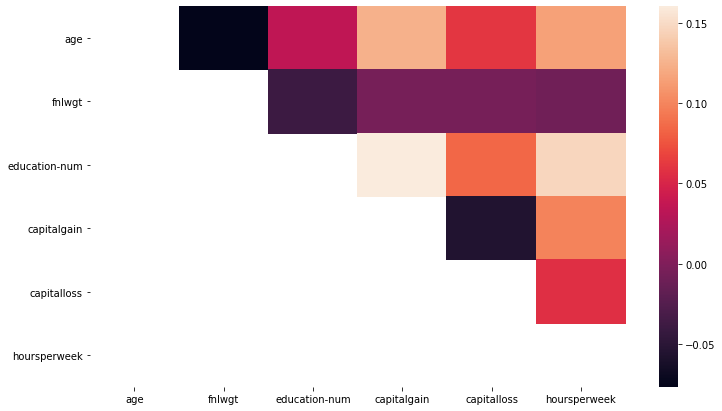

In [273]:
correlation_features_drop(df_new, 0.8)

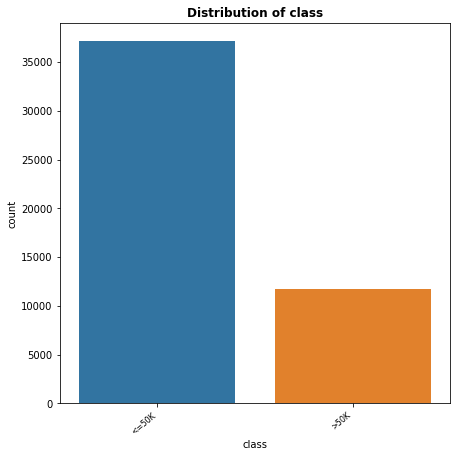

In [275]:
count_plot(df_new, 'class')

In [277]:
remove_constant_column(df_new)

There are some features with constant value or 100% null:  0


[]

In [265]:
df_af = df_new[df_new['native-country'] == 'United-States']
df_white = df_af[df_af['race'] == 'White']
#df_master = df_white[df_white['education'] == 'Masters']
df_white

age         workclass  fnlwgt  education  education-num      marital-status         occupation   relationship   race     sex  capitalgain  capitalloss  hoursperweek native-country  class
0        2         State-gov   77516  Bachelors             13       Never-married       Adm-clerical  Not-in-family  White    Male            1            0             2  United-States  <=50K
1        3  Self-emp-not-inc   83311  Bachelors             13  Married-civ-spouse    Exec-managerial        Husband  White    Male            0            0             0  United-States  <=50K
2        2           Private  215646    HS-grad              9            Divorced  Handlers-cleaners  Not-in-family  White    Male            0            0             2  United-States  <=50K
5        2           Private  284582    Masters             14  Married-civ-spouse    Exec-managerial           Wife  White  Female            0            0             2  United-States  <=50K
7        3  Self-emp-not-inc  209642    HS-grad              9  Married-civ-spouse    Exec-managerial        Husband  White    Male            0            0             2  United-States   >50K
...    ...               ...     ...        ...            ...                 ...                ...            ...    ...     ...          ...          ...           ...            ...    ...
48835    3         Local-gov  349230    Masters             14            Divorced      Other-service  Not-in-family  White    Male            0            0             2  United-States  <=50K
48836    1           Private  245211  Bachelors             13       Never-married     Prof-specialty      Own-child  White    Male            0            0             2  United-States  <=50K
48837    2           Private  215419  Bachelors             13            Divorced     Prof-specialty  Not-in-family  White  Female            0            0             2  United-States  <=50K
48839    2           Private  374983  Bachelors             13  Married-civ-spouse     Prof-specialty        Husband  White    Male            0            0             3  United-States  <=50K
48841    1      Self-emp-inc  182148  Bachelors             13  Married-civ-spouse    Exec-managerial        Husband  White    Male            0            0             3  United-States   >50K

[38493 rows x 15 columns]

In [262]:
eda_columns(df_new, 'marital-status')

In [267]:
# Race: white
# Live: USA 
eda_columns(df_white, 'class')

In [269]:
eda_columns(df_white[df_white['sex'] == 'Male'], 'class')

In [270]:
eda_columns(df_white[df_white['sex'] == 'Female'], 'class')

# End